In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/TableNet-pytorch/Training

/content/drive/MyDrive/TableNet-pytorch/Training


In [3]:
import pandas as pd
testdf = pd.read_csv('../processed_data_v2.csv')
testdf.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,marmot_processed\image_v2\10.1.1.1.2000_4.jpg,marmot_processed\table_mask\10.1.1.1.2000_4_ta...,marmot_processed\col_mask\10.1.1.1.2000_4_col_...,1008,768,0,0,0,[],[]
1,marmot_processed\image_v2\10.1.1.1.2004_4.jpg,marmot_processed\table_mask\10.1.1.1.2004_4_ta...,marmot_processed\col_mask\10.1.1.1.2004_4_col_...,1123,793,0,0,0,[],[]
2,marmot_processed\image_v2\10.1.1.1.2004_5.jpg,marmot_processed\table_mask\10.1.1.1.2004_5_ta...,marmot_processed\col_mask\10.1.1.1.2004_5_col_...,1123,793,0,0,0,[],[]
3,marmot_processed\image_v2\10.1.1.1.2005_12.jpg,marmot_processed\table_mask\10.1.1.1.2005_12_t...,marmot_processed\col_mask\10.1.1.1.2005_12_col...,1056,816,0,0,0,[],[]
4,marmot_processed\image_v2\10.1.1.1.2005_13.jpg,marmot_processed\table_mask\10.1.1.1.2005_13_t...,marmot_processed\col_mask\10.1.1.1.2005_13_col...,1056,816,0,0,0,[],[]


In [6]:
%pip install efficientnet_pytorch pytorch_model_summary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6

In [5]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import config
import os
from utils import (
    get_data_loaders,
    load_checkpoint,
    save_checkpoint,
    display_metrics,
    write_summary,
    compute_metrics,
    seed_all
    )
from loss import TableNetLoss
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from model import TableNet
from torch.utils.tensorboard import SummaryWriter
from pytorch_model_summary import summary


In [6]:
import sys
import warnings
warnings.filterwarnings("ignore")

In [7]:
def train_on_epoch(data_loader, model, optimizer, loss, scaler, threshold = 0.5):
    print("in train_on_epoch")
    # metrics = 0
    combined_loss = []
    table_loss, table_acc, table_precision, table_recall, table_f1 = [],[],[],[],[]
    col_loss, col_acc, col_precision, col_recall, col_f1 = [],[],[],[],[]

    loop = tqdm(data_loader, leave=True)
    # print("THIS IS LOOP",len(list(data_loader)), loop, "THIS IS LOOP")

    for batch_idx, img_dict in enumerate(loop):
        image           = img_dict["image"].to(config.DEVICE)
        table_image     = img_dict["table_image"].to(config.DEVICE)
        column_image     = img_dict["column_image"].to(config.DEVICE)

        with torch.cuda.amp.autocast():
            table_out, column_out  = model(image)
            t_loss, c_loss = loss(table_out, table_image, column_out, column_image)
        table_loss.append(t_loss.item())
        col_loss.append(c_loss.item())
        combined_loss.append((t_loss + c_loss).item())

        #backward
        optimizer.zero_grad()
        scaler.scale(t_loss + c_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        mean_loss = sum(combined_loss) / len(combined_loss)
        loop.set_postfix(loss=mean_loss)

        cal_metrics_table = compute_metrics(table_image, table_out, threshold)
        cal_metrics_col = compute_metrics(column_image, column_out, threshold)

        table_f1.append(cal_metrics_table['f1'])
        table_precision.append(cal_metrics_table['precision'])
        table_acc.append(cal_metrics_table['acc'])
        table_recall.append(cal_metrics_table['recall'])
        col_f1.append(cal_metrics_col['f1'])
        col_acc.append(cal_metrics_col['acc'])
        col_precision.append(cal_metrics_col['precision'])
        col_recall.append(cal_metrics_col['recall'])

        metrics = {
        'combined_loss': np.mean(combined_loss),
        'table_loss': np.mean(table_loss),
        'column_loss': np.mean(col_loss),
        'table_f1': np.mean(table_f1),
        'col_f1': np.mean(col_f1),
        'table_precision': np.mean(table_precision),
        'col_precision': np.mean(col_precision),
        'table_recall': np.mean(table_recall),
        'col_recall': np.mean(col_recall),
        'table_acc': np.mean(table_acc),
        'col_acc': np.mean(col_acc)
        }

    return metrics



In [8]:
def test_on_epoch(data_loader, model, loss, threshold = 0.5, device = config.DEVICE):

    combined_loss = []
    table_loss, table_acc, table_precision, table_recall, table_f1 = [],[],[],[],[]
    col_loss, col_acc, col_precision, col_recall, col_f1 = [],[],[],[],[]

    model.eval()
    with torch.no_grad():
        loop = tqdm(data_loader, leave=True)

        for batch_idx, img_dict in enumerate(loop):
            image           = img_dict["image"].to(device)
            table_image     = img_dict["table_image"].to(device)
            column_image     = img_dict["column_image"].to(device)

            with torch.cuda.amp.autocast():
                table_out, column_out  = model(image)

                t_loss, c_loss = loss(table_out, table_image, column_out, column_image)
            table_loss.append(t_loss.item())
            col_loss.append(c_loss.item())
            combined_loss.append((t_loss + c_loss).item())

            mean_loss = sum(combined_loss) / len(combined_loss)
            loop.set_postfix(loss=mean_loss)

            #cal_metrics = compute_metrics(table_image, column_image, table_out, column_out, threshold)

            cal_metrics_table = compute_metrics(table_image, table_out, threshold)
            cal_metrics_col = compute_metrics(column_image, column_out, threshold)


            table_f1.append(cal_metrics_table['f1'])
            table_precision.append(cal_metrics_table['precision'])
            table_acc.append(cal_metrics_table['acc'])
            table_recall.append(cal_metrics_table['recall'])
            col_f1.append(cal_metrics_col['f1'])
            col_acc.append(cal_metrics_col['acc'])
            col_precision.append(cal_metrics_col['precision'])
            col_recall.append(cal_metrics_col['recall'])



    metrics = {
        'combined_loss': np.mean(combined_loss),
        'table_loss': np.mean(table_loss),
        'column_loss': np.mean(col_loss),
        'table_f1': np.mean(table_f1),
        'col_f1': np.mean(col_f1),
        'table_precision': np.mean(table_precision),
        'col_precision': np.mean(col_precision),
        'table_recall': np.mean(table_recall),
        'col_recall': np.mean(col_recall),
        'table_acc': np.mean(table_acc),
        'col_acc': np.mean(col_acc)
    }

    model.train()
    return metrics


In [9]:
checkpoint_name = 'densenet_config_4_model_checkpoint.pth.tar'
os.path.exists(checkpoint_name)

True

In [ ]:
os.path(checkpoint_name)

TypeError: 'module' object is not callable

In [10]:
if __name__ == '__main__':
    # print("1")
    seed_all(SEED_VALUE = config.SEED)
    checkpoint_name = 'densenet_config_4_model_checkpoint.pth.tar'
    model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)
    # print("2")


    print("Model Architecture and Trainable Paramerters")
    print("="*50)
    # print("3")
    print(summary(model, torch.zeros((1, 3, 1024, 1024)), show_input=False, show_hierarchical=True))
    # print("4")
    print(config.DEVICE)

    model = model.to(config.DEVICE)
    # print("5")
    optimizer = optim.Adam(
        model.parameters(),
        lr = config.LEARNING_RATE,
        weight_decay = config.WEIGHT_DECAY,
        )
    loss = TableNetLoss()
    # print("6")
    scaler = torch.cuda.amp.GradScaler()
    # print("7")
    train_loader, test_loader = get_data_loaders(data_path = config.DATAPATH)
    # print("8")

    nl = '\n'

    #load checkpoint
    if os.path.exists(checkpoint_name):
        last_epoch, tr_metrics,te_metrics = load_checkpoint(torch.load(checkpoint_name), model)
        last_table_f1 = te_metrics['table_f1']
        last_col_f1 = te_metrics['col_f1']

        print("Loading Checkpoint")
        display_metrics(last_epoch, tr_metrics,te_metrics)
        # print("9")
        print()
    else:
        last_epoch = 0
        last_table_f1 = 0.
        last_col_f1 = 0.

    #Train Network
    print("Training Model\n")
    # print("9")
    writer = SummaryWriter(
            f"runs/TableNet/densenet/config_4_batch_{config.BATCH_SIZE}_LR_{config.LEARNING_RATE}_encoder_train"
        )

    #for early stopping
    i = 0
    # print("10")

    for epoch in range(last_epoch + 1,config.EPOCHS):
    # for epoch in range(last_epoch + 1,3):
        # print("11")
        print("="*30)
        start = time.time()

        tr_metrics = train_on_epoch(train_loader, model, optimizer, loss, scaler, 0.5)
        # print("12")
        te_metrics = test_on_epoch(test_loader, model, loss, threshold = 0.5)

        write_summary(writer, tr_metrics, te_metrics, epoch)

        end = time.time()

        display_metrics(epoch, tr_metrics,te_metrics)

        if last_table_f1 < te_metrics['table_f1'] or last_col_f1 < te_metrics['col_f1']:

            #i = 0
            last_table_f1 = te_metrics['table_f1']
            last_col_f1 = te_metrics['col_f1']

            checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'train_metrics': tr_metrics, 'test_metrics': te_metrics}
            save_checkpoint(checkpoint, checkpoint_name)
        else:
           i += 1

        # if i == 12:
        #    print("Early Stopping")
        #    break


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 67.5MB/s]


Model Architecture and Trainable Paramerters
-------------------------------------------------------------------------------------------------------------
      Layer (type)                                              Output Shape         Param #     Tr. Param #
        DenseNet-1     [1, 256, 64, 64], [1, 512, 32, 32], [1, 1024, 32, 32]       6,951,808       6,951,808
          Conv2d-2                                          [1, 256, 32, 32]         262,400         262,400
            ReLU-3                                          [1, 256, 32, 32]               0               0
         Dropout-4                                          [1, 256, 32, 32]               0               0
          Conv2d-5                                          [1, 256, 32, 32]          65,792          65,792
            ReLU-6                                          [1, 256, 32, 32]               0               0
         Dropout-7                                          [1, 256, 32, 32]      

100%|██████████| 25/25 [01:23<00:00,  3.35s/it, loss=0.128]


Epoch: 63 
            Table Loss -- Train: 0.015 Test: 0.068
            Table Acc -- Train: 0.995 Test: 0.979
            Table F1 -- Train: 0.714 Test: 0.886
            Table Precision -- Train: 0.715 Test: 0.914
            Table Recall -- Train: 0.714 Test: 0.869
            
            Col Loss -- Train: 0.028 Test: 0.060
            Col Acc -- Train: 0.989 Test: 0.978
            Col F1 -- Train: 0.655 Test: 0.833
            Col Precision -- Train: 0.654 Test: 0.807
            Col Recall -- Train: 0.662 Test: 0.872
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.67it/s, loss=0.178]


Epoch: 64 
            Table Loss -- Train: 0.016 Test: 0.090
            Table Acc -- Train: 0.994 Test: 0.981
            Table F1 -- Train: 0.731 Test: 0.901
            Table Precision -- Train: 0.733 Test: 0.844
            Table Recall -- Train: 0.730 Test: 0.980
            
            Col Loss -- Train: 0.028 Test: 0.087
            Col Acc -- Train: 0.989 Test: 0.975
            Col F1 -- Train: 0.673 Test: 0.800
            Col Precision -- Train: 0.676 Test: 0.761
            Col Recall -- Train: 0.678 Test: 0.868
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.67it/s, loss=0.308]


Epoch: 65 
            Table Loss -- Train: 0.019 Test: 0.149
            Table Acc -- Train: 0.993 Test: 0.958
            Table F1 -- Train: 0.712 Test: 0.743
            Table Precision -- Train: 0.714 Test: 0.618
            Table Recall -- Train: 0.713 Test: 0.972
            
            Col Loss -- Train: 0.031 Test: 0.160
            Col Acc -- Train: 0.987 Test: 0.955
            Col F1 -- Train: 0.651 Test: 0.538
            Col Precision -- Train: 0.652 Test: 0.407
            Col Recall -- Train: 0.660 Test: 0.902
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.69it/s, loss=0.0873]


Epoch: 66 
            Table Loss -- Train: 0.020 Test: 0.041
            Table Acc -- Train: 0.993 Test: 0.987
            Table F1 -- Train: 0.727 Test: 0.931
            Table Precision -- Train: 0.728 Test: 0.898
            Table Recall -- Train: 0.730 Test: 0.974
            
            Col Loss -- Train: 0.029 Test: 0.046
            Col Acc -- Train: 0.989 Test: 0.983
            Col F1 -- Train: 0.673 Test: 0.857
            Col Precision -- Train: 0.675 Test: 0.809
            Col Recall -- Train: 0.676 Test: 0.920
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.65it/s, loss=0.0741]


Epoch: 67 
            Table Loss -- Train: 0.017 Test: 0.034
            Table Acc -- Train: 0.994 Test: 0.989
            Table F1 -- Train: 0.722 Test: 0.940
            Table Precision -- Train: 0.724 Test: 0.917
            Table Recall -- Train: 0.724 Test: 0.968
            
            Col Loss -- Train: 0.028 Test: 0.040
            Col Acc -- Train: 0.989 Test: 0.984
            Col F1 -- Train: 0.668 Test: 0.874
            Col Precision -- Train: 0.669 Test: 0.841
            Col Recall -- Train: 0.675 Test: 0.918
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.61it/s, loss=0.0657]


Epoch: 68 
            Table Loss -- Train: 0.012 Test: 0.031
            Table Acc -- Train: 0.996 Test: 0.990
            Table F1 -- Train: 0.736 Test: 0.946
            Table Precision -- Train: 0.736 Test: 0.940
            Table Recall -- Train: 0.736 Test: 0.956
            
            Col Loss -- Train: 0.025 Test: 0.035
            Col Acc -- Train: 0.990 Test: 0.986
            Col F1 -- Train: 0.679 Test: 0.888
            Col Precision -- Train: 0.677 Test: 0.878
            Col Recall -- Train: 0.686 Test: 0.903
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.67it/s, loss=0.0818]


Epoch: 69 
            Table Loss -- Train: 0.012 Test: 0.039
            Table Acc -- Train: 0.996 Test: 0.989
            Table F1 -- Train: 0.726 Test: 0.944
            Table Precision -- Train: 0.728 Test: 0.925
            Table Recall -- Train: 0.726 Test: 0.969
            
            Col Loss -- Train: 0.024 Test: 0.043
            Col Acc -- Train: 0.991 Test: 0.984
            Col F1 -- Train: 0.673 Test: 0.874
            Col Precision -- Train: 0.672 Test: 0.836
            Col Recall -- Train: 0.677 Test: 0.923
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.70it/s, loss=0.109]


Epoch: 70 
            Table Loss -- Train: 0.030 Test: 0.057
            Table Acc -- Train: 0.991 Test: 0.979
            Table F1 -- Train: 0.688 Test: 0.895
            Table Precision -- Train: 0.692 Test: 0.929
            Table Recall -- Train: 0.695 Test: 0.869
            
            Col Loss -- Train: 0.034 Test: 0.052
            Col Acc -- Train: 0.986 Test: 0.978
            Col F1 -- Train: 0.639 Test: 0.841
            Col Precision -- Train: 0.639 Test: 0.893
            Col Recall -- Train: 0.653 Test: 0.803
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.69it/s, loss=0.0832]


Epoch: 71 
            Table Loss -- Train: 0.023 Test: 0.038
            Table Acc -- Train: 0.992 Test: 0.987
            Table F1 -- Train: 0.712 Test: 0.934
            Table Precision -- Train: 0.714 Test: 0.915
            Table Recall -- Train: 0.717 Test: 0.958
            
            Col Loss -- Train: 0.033 Test: 0.045
            Col Acc -- Train: 0.986 Test: 0.983
            Col F1 -- Train: 0.658 Test: 0.856
            Col Precision -- Train: 0.659 Test: 0.809
            Col Recall -- Train: 0.665 Test: 0.920
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.68it/s, loss=0.0803]


Epoch: 72 
            Table Loss -- Train: 0.013 Test: 0.035
            Table Acc -- Train: 0.996 Test: 0.989
            Table F1 -- Train: 0.737 Test: 0.945
            Table Precision -- Train: 0.738 Test: 0.930
            Table Recall -- Train: 0.738 Test: 0.963
            
            Col Loss -- Train: 0.025 Test: 0.045
            Col Acc -- Train: 0.990 Test: 0.982
            Col F1 -- Train: 0.678 Test: 0.863
            Col Precision -- Train: 0.675 Test: 0.845
            Col Recall -- Train: 0.687 Test: 0.891
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0705]


Epoch: 73 
            Table Loss -- Train: 0.011 Test: 0.031
            Table Acc -- Train: 0.996 Test: 0.991
            Table F1 -- Train: 0.730 Test: 0.950
            Table Precision -- Train: 0.731 Test: 0.938
            Table Recall -- Train: 0.729 Test: 0.965
            
            Col Loss -- Train: 0.022 Test: 0.040
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.682 Test: 0.880
            Col Precision -- Train: 0.682 Test: 0.856
            Col Recall -- Train: 0.685 Test: 0.912
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0737]


Epoch: 74 
            Table Loss -- Train: 0.011 Test: 0.034
            Table Acc -- Train: 0.996 Test: 0.990
            Table F1 -- Train: 0.712 Test: 0.943
            Table Precision -- Train: 0.714 Test: 0.912
            Table Recall -- Train: 0.711 Test: 0.979
            
            Col Loss -- Train: 0.022 Test: 0.039
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.663 Test: 0.878
            Col Precision -- Train: 0.660 Test: 0.841
            Col Recall -- Train: 0.669 Test: 0.922
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0721]


Epoch: 75 
            Table Loss -- Train: 0.011 Test: 0.034
            Table Acc -- Train: 0.996 Test: 0.990
            Table F1 -- Train: 0.710 Test: 0.949
            Table Precision -- Train: 0.711 Test: 0.938
            Table Recall -- Train: 0.710 Test: 0.962
            
            Col Loss -- Train: 0.022 Test: 0.038
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.666 Test: 0.886
            Col Precision -- Train: 0.665 Test: 0.861
            Col Recall -- Train: 0.669 Test: 0.916
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0926]


Epoch: 76 
            Table Loss -- Train: 0.013 Test: 0.044
            Table Acc -- Train: 0.996 Test: 0.988
            Table F1 -- Train: 0.745 Test: 0.938
            Table Precision -- Train: 0.747 Test: 0.909
            Table Recall -- Train: 0.745 Test: 0.971
            
            Col Loss -- Train: 0.023 Test: 0.049
            Col Acc -- Train: 0.991 Test: 0.983
            Col F1 -- Train: 0.698 Test: 0.873
            Col Precision -- Train: 0.699 Test: 0.864
            Col Recall -- Train: 0.701 Test: 0.888
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.67it/s, loss=0.223]


Epoch: 77 
            Table Loss -- Train: 0.012 Test: 0.122
            Table Acc -- Train: 0.996 Test: 0.979
            Table F1 -- Train: 0.738 Test: 0.891
            Table Precision -- Train: 0.739 Test: 0.831
            Table Recall -- Train: 0.739 Test: 0.976
            
            Col Loss -- Train: 0.022 Test: 0.100
            Col Acc -- Train: 0.991 Test: 0.978
            Col F1 -- Train: 0.689 Test: 0.830
            Col Precision -- Train: 0.686 Test: 0.787
            Col Recall -- Train: 0.694 Test: 0.897
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.71it/s, loss=0.166]


Epoch: 78 
            Table Loss -- Train: 0.027 Test: 0.080
            Table Acc -- Train: 0.991 Test: 0.974
            Table F1 -- Train: 0.705 Test: 0.840
            Table Precision -- Train: 0.708 Test: 0.749
            Table Recall -- Train: 0.711 Test: 0.986
            
            Col Loss -- Train: 0.037 Test: 0.085
            Col Acc -- Train: 0.986 Test: 0.972
            Col F1 -- Train: 0.646 Test: 0.754
            Col Precision -- Train: 0.645 Test: 0.680
            Col Recall -- Train: 0.658 Test: 0.885
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.58it/s, loss=0.0938]


Epoch: 79 
            Table Loss -- Train: 0.023 Test: 0.047
            Table Acc -- Train: 0.992 Test: 0.986
            Table F1 -- Train: 0.711 Test: 0.932
            Table Precision -- Train: 0.711 Test: 0.927
            Table Recall -- Train: 0.719 Test: 0.941
            
            Col Loss -- Train: 0.033 Test: 0.047
            Col Acc -- Train: 0.987 Test: 0.983
            Col F1 -- Train: 0.649 Test: 0.870
            Col Precision -- Train: 0.647 Test: 0.857
            Col Recall -- Train: 0.665 Test: 0.890
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0707]


Epoch: 80 
            Table Loss -- Train: 0.015 Test: 0.033
            Table Acc -- Train: 0.995 Test: 0.990
            Table F1 -- Train: 0.717 Test: 0.946
            Table Precision -- Train: 0.720 Test: 0.938
            Table Recall -- Train: 0.716 Test: 0.958
            
            Col Loss -- Train: 0.027 Test: 0.037
            Col Acc -- Train: 0.989 Test: 0.985
            Col F1 -- Train: 0.667 Test: 0.886
            Col Precision -- Train: 0.669 Test: 0.879
            Col Recall -- Train: 0.671 Test: 0.898
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:16<00:00,  1.55it/s, loss=0.154]


Epoch: 81 
            Table Loss -- Train: 0.023 Test: 0.080
            Table Acc -- Train: 0.992 Test: 0.978
            Table F1 -- Train: 0.717 Test: 0.884
            Table Precision -- Train: 0.722 Test: 0.819
            Table Recall -- Train: 0.720 Test: 0.973
            
            Col Loss -- Train: 0.033 Test: 0.073
            Col Acc -- Train: 0.987 Test: 0.975
            Col F1 -- Train: 0.657 Test: 0.793
            Col Precision -- Train: 0.657 Test: 0.726
            Col Recall -- Train: 0.670 Test: 0.898
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.60it/s, loss=0.0843]


Epoch: 82 
            Table Loss -- Train: 0.025 Test: 0.037
            Table Acc -- Train: 0.992 Test: 0.988
            Table F1 -- Train: 0.713 Test: 0.939
            Table Precision -- Train: 0.716 Test: 0.919
            Table Recall -- Train: 0.720 Test: 0.965
            
            Col Loss -- Train: 0.032 Test: 0.047
            Col Acc -- Train: 0.987 Test: 0.983
            Col F1 -- Train: 0.663 Test: 0.876
            Col Precision -- Train: 0.666 Test: 0.881
            Col Recall -- Train: 0.672 Test: 0.879
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.64it/s, loss=0.0639]


Epoch: 83 
            Table Loss -- Train: 0.026 Test: 0.028
            Table Acc -- Train: 0.992 Test: 0.990
            Table F1 -- Train: 0.701 Test: 0.947
            Table Precision -- Train: 0.705 Test: 0.929
            Table Recall -- Train: 0.704 Test: 0.968
            
            Col Loss -- Train: 0.037 Test: 0.035
            Col Acc -- Train: 0.987 Test: 0.985
            Col F1 -- Train: 0.645 Test: 0.887
            Col Precision -- Train: 0.645 Test: 0.881
            Col Recall -- Train: 0.656 Test: 0.898
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.65it/s, loss=0.0774]


Epoch: 84 
            Table Loss -- Train: 0.012 Test: 0.037
            Table Acc -- Train: 0.996 Test: 0.989
            Table F1 -- Train: 0.737 Test: 0.943
            Table Precision -- Train: 0.739 Test: 0.924
            Table Recall -- Train: 0.737 Test: 0.966
            
            Col Loss -- Train: 0.024 Test: 0.040
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.685 Test: 0.882
            Col Precision -- Train: 0.685 Test: 0.870
            Col Recall -- Train: 0.689 Test: 0.900
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.67it/s, loss=0.086]


Epoch: 85 
            Table Loss -- Train: 0.011 Test: 0.042
            Table Acc -- Train: 0.996 Test: 0.988
            Table F1 -- Train: 0.715 Test: 0.937
            Table Precision -- Train: 0.716 Test: 0.903
            Table Recall -- Train: 0.715 Test: 0.980
            
            Col Loss -- Train: 0.022 Test: 0.044
            Col Acc -- Train: 0.991 Test: 0.984
            Col F1 -- Train: 0.665 Test: 0.877
            Col Precision -- Train: 0.662 Test: 0.849
            Col Recall -- Train: 0.671 Test: 0.914
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.67it/s, loss=0.089]


Epoch: 86 
            Table Loss -- Train: 0.011 Test: 0.041
            Table Acc -- Train: 0.996 Test: 0.987
            Table F1 -- Train: 0.718 Test: 0.935
            Table Precision -- Train: 0.719 Test: 0.917
            Table Recall -- Train: 0.717 Test: 0.959
            
            Col Loss -- Train: 0.022 Test: 0.048
            Col Acc -- Train: 0.992 Test: 0.982
            Col F1 -- Train: 0.673 Test: 0.855
            Col Precision -- Train: 0.673 Test: 0.797
            Col Recall -- Train: 0.676 Test: 0.932
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.65it/s, loss=0.0826]


Epoch: 87 
            Table Loss -- Train: 0.013 Test: 0.043
            Table Acc -- Train: 0.995 Test: 0.989
            Table F1 -- Train: 0.737 Test: 0.941
            Table Precision -- Train: 0.739 Test: 0.910
            Table Recall -- Train: 0.736 Test: 0.977
            
            Col Loss -- Train: 0.023 Test: 0.040
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.690 Test: 0.887
            Col Precision -- Train: 0.689 Test: 0.870
            Col Recall -- Train: 0.695 Test: 0.909
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.69it/s, loss=0.0765]


Epoch: 88 
            Table Loss -- Train: 0.011 Test: 0.037
            Table Acc -- Train: 0.996 Test: 0.990
            Table F1 -- Train: 0.725 Test: 0.945
            Table Precision -- Train: 0.726 Test: 0.931
            Table Recall -- Train: 0.724 Test: 0.962
            
            Col Loss -- Train: 0.022 Test: 0.040
            Col Acc -- Train: 0.991 Test: 0.985
            Col F1 -- Train: 0.674 Test: 0.879
            Col Precision -- Train: 0.675 Test: 0.849
            Col Recall -- Train: 0.678 Test: 0.917
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.77it/s, loss=0.0867]


Epoch: 89 
            Table Loss -- Train: 0.011 Test: 0.046
            Table Acc -- Train: 0.996 Test: 0.988
            Table F1 -- Train: 0.741 Test: 0.940
            Table Precision -- Train: 0.743 Test: 0.913
            Table Recall -- Train: 0.741 Test: 0.974
            
            Col Loss -- Train: 0.021 Test: 0.040
            Col Acc -- Train: 0.992 Test: 0.985
            Col F1 -- Train: 0.692 Test: 0.879
            Col Precision -- Train: 0.688 Test: 0.835
            Col Recall -- Train: 0.699 Test: 0.934
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.72it/s, loss=0.0993]


Epoch: 90 
            Table Loss -- Train: 0.018 Test: 0.052
            Table Acc -- Train: 0.994 Test: 0.981
            Table F1 -- Train: 0.727 Test: 0.901
            Table Precision -- Train: 0.729 Test: 0.928
            Table Recall -- Train: 0.729 Test: 0.883
            
            Col Loss -- Train: 0.024 Test: 0.048
            Col Acc -- Train: 0.991 Test: 0.981
            Col F1 -- Train: 0.682 Test: 0.854
            Col Precision -- Train: 0.679 Test: 0.840
            Col Recall -- Train: 0.689 Test: 0.876
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.76it/s, loss=0.0975]


Epoch: 91 
            Table Loss -- Train: 0.035 Test: 0.045
            Table Acc -- Train: 0.988 Test: 0.985
            Table F1 -- Train: 0.704 Test: 0.920
            Table Precision -- Train: 0.707 Test: 0.871
            Table Recall -- Train: 0.710 Test: 0.982
            
            Col Loss -- Train: 0.039 Test: 0.053
            Col Acc -- Train: 0.985 Test: 0.980
            Col F1 -- Train: 0.647 Test: 0.850
            Col Precision -- Train: 0.647 Test: 0.825
            Col Recall -- Train: 0.661 Test: 0.887
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.73it/s, loss=0.0747]


Epoch: 92 
            Table Loss -- Train: 0.015 Test: 0.037
            Table Acc -- Train: 0.995 Test: 0.989
            Table F1 -- Train: 0.722 Test: 0.940
            Table Precision -- Train: 0.723 Test: 0.910
            Table Recall -- Train: 0.723 Test: 0.977
            
            Col Loss -- Train: 0.025 Test: 0.038
            Col Acc -- Train: 0.990 Test: 0.985
            Col F1 -- Train: 0.673 Test: 0.885
            Col Precision -- Train: 0.673 Test: 0.861
            Col Recall -- Train: 0.677 Test: 0.916
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.72it/s, loss=0.0879]


Epoch: 93 
            Table Loss -- Train: 0.011 Test: 0.042
            Table Acc -- Train: 0.996 Test: 0.988
            Table F1 -- Train: 0.718 Test: 0.935
            Table Precision -- Train: 0.719 Test: 0.896
            Table Recall -- Train: 0.718 Test: 0.982
            
            Col Loss -- Train: 0.022 Test: 0.046
            Col Acc -- Train: 0.992 Test: 0.984
            Col F1 -- Train: 0.670 Test: 0.875
            Col Precision -- Train: 0.669 Test: 0.849
            Col Recall -- Train: 0.675 Test: 0.911
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.70it/s, loss=0.0777]


Epoch: 94 
            Table Loss -- Train: 0.020 Test: 0.038
            Table Acc -- Train: 0.993 Test: 0.988
            Table F1 -- Train: 0.721 Test: 0.938
            Table Precision -- Train: 0.720 Test: 0.917
            Table Recall -- Train: 0.723 Test: 0.966
            
            Col Loss -- Train: 0.026 Test: 0.040
            Col Acc -- Train: 0.990 Test: 0.985
            Col F1 -- Train: 0.665 Test: 0.881
            Col Precision -- Train: 0.663 Test: 0.857
            Col Recall -- Train: 0.675 Test: 0.914
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.69it/s, loss=0.103]


Epoch: 95 
            Table Loss -- Train: 0.013 Test: 0.051
            Table Acc -- Train: 0.996 Test: 0.987
            Table F1 -- Train: 0.726 Test: 0.930
            Table Precision -- Train: 0.727 Test: 0.899
            Table Recall -- Train: 0.725 Test: 0.973
            
            Col Loss -- Train: 0.023 Test: 0.053
            Col Acc -- Train: 0.991 Test: 0.981
            Col F1 -- Train: 0.679 Test: 0.862
            Col Precision -- Train: 0.677 Test: 0.872
            Col Recall -- Train: 0.683 Test: 0.865
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.70it/s, loss=0.0944]


Epoch: 96 
            Table Loss -- Train: 0.010 Test: 0.048
            Table Acc -- Train: 0.996 Test: 0.987
            Table F1 -- Train: 0.738 Test: 0.935
            Table Precision -- Train: 0.739 Test: 0.912
            Table Recall -- Train: 0.738 Test: 0.965
            
            Col Loss -- Train: 0.021 Test: 0.047
            Col Acc -- Train: 0.992 Test: 0.984
            Col F1 -- Train: 0.695 Test: 0.882
            Col Precision -- Train: 0.693 Test: 0.904
            Col Recall -- Train: 0.698 Test: 0.868
        
in train_on_epoch


100%|██████████| 25/25 [00:15<00:00,  1.66it/s, loss=0.0807]


Epoch: 97 
            Table Loss -- Train: 0.010 Test: 0.042
            Table Acc -- Train: 0.996 Test: 0.989
            Table F1 -- Train: 0.737 Test: 0.941
            Table Precision -- Train: 0.738 Test: 0.913
            Table Recall -- Train: 0.737 Test: 0.976
            
            Col Loss -- Train: 0.020 Test: 0.039
            Col Acc -- Train: 0.992 Test: 0.986
            Col F1 -- Train: 0.691 Test: 0.888
            Col Precision -- Train: 0.688 Test: 0.868
            Col Recall -- Train: 0.694 Test: 0.916
        
Checkpoint Saved at  densenet_config_4_model_checkpoint.pth.tar
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.70it/s, loss=0.103]


Epoch: 98 
            Table Loss -- Train: 0.010 Test: 0.049
            Table Acc -- Train: 0.996 Test: 0.987
            Table F1 -- Train: 0.732 Test: 0.935
            Table Precision -- Train: 0.733 Test: 0.910
            Table Recall -- Train: 0.731 Test: 0.967
            
            Col Loss -- Train: 0.020 Test: 0.054
            Col Acc -- Train: 0.992 Test: 0.982
            Col F1 -- Train: 0.684 Test: 0.856
            Col Precision -- Train: 0.682 Test: 0.798
            Col Recall -- Train: 0.689 Test: 0.935
        
in train_on_epoch


100%|██████████| 25/25 [00:14<00:00,  1.68it/s, loss=0.088]

Epoch: 99 
            Table Loss -- Train: 0.011 Test: 0.042
            Table Acc -- Train: 0.996 Test: 0.987
            Table F1 -- Train: 0.720 Test: 0.933
            Table Precision -- Train: 0.722 Test: 0.939
            Table Recall -- Train: 0.720 Test: 0.932
            
            Col Loss -- Train: 0.023 Test: 0.046
            Col Acc -- Train: 0.991 Test: 0.982
            Col F1 -- Train: 0.667 Test: 0.875
            Col Precision -- Train: 0.664 Test: 0.929
            Col Recall -- Train: 0.673 Test: 0.832
        


In [3]:
%pip install pytesseract

In [7]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
from datetime import datetime
import torch
import torch.nn as nn
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytesseract
from io import StringIO
from model import TableNet

In [8]:
TRANSFORM = A.Compose([
                #ToTensor --> Normalize(mean, std)
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                    max_pixel_value = 255,
                ),
                ToTensorV2()
    ])

In [10]:
# model = TableNet(encoder = 'densenet', use_pretrained_model = True, basemodel_requires_grad = True)
# model.eval()

# #load checkpoint
# model.load_state_dict(torch.load("densenet_config_4_model_checkpoint.pth.tar")['state_dict'])

# Load checkpoint and map tensors to CPU
checkpoint = torch.load("densenet_config_4_model_checkpoint.pth.tar", map_location=torch.device('cpu'))
# Load model state dictionary
model.load_state_dict(checkpoint['state_dict'])
model.eval()

TableNet(
  (base_model): DenseNet(
    (densenet_out_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
def predict(img_path):
    orig_image = Image.open(img_path).resize((1024, 1024))
    test_img = np.array(orig_image.convert('LA').convert("RGB"))

    now = datetime.now()
    image = TRANSFORM(image = test_img)["image"]
    with torch.no_grad():
        image = image.unsqueeze(0)
        #with torch.cuda.amp.autocast():
        table_out, _  = model(image)
        table_out = torch.sigmoid(table_out)

    #remove gradients
    table_out = (table_out.detach().numpy().squeeze(0).transpose(1,2,0) > 0.5).astype(np.uint8)

    #get contours of the mask to get number of tables
    contours, table_heirarchy = cv2.findContours(table_out, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    table_contours = []
    #ref: https://www.pyimagesearch.com/2015/02/09/removing-contours-image-using-python-opencv/
    #remove bad contours
    for c in contours:

        if cv2.contourArea(c) > 3000:
            table_contours.append(c)

    if len(table_contours) == 0:
        print("No Table detected")

    table_boundRect = [None]*len(table_contours)
    for i, c in enumerate(table_contours):
        polygon = cv2.approxPolyDP(c, 3, True)
        table_boundRect[i] = cv2.boundingRect(polygon)

    #table bounding Box
    table_boundRect.sort()

    orig_image = np.array(orig_image)
    #draw bounding boxes
    color = (0,0,255)
    thickness = 4

    for x,y,w,h in table_boundRect:
        cv2.rectangle(orig_image, (x,y),(x+w,y+h), color, thickness)

    plt.figure(figsize = (20,10))
    plt.imshow(orig_image)
    plt.show()

    end_time = datetime.now()
    difference = end_time - now
    #print("Total Time : {} seconds".format(difference))
    time = "{}".format(difference)

    print(f"Time Taken on cpu : {time} secs")

    print("Predicted Tables")

    image = test_img[...,0].reshape(1024, 1024).astype(np.uint8)

    for i,(x,y,w,h) in enumerate(table_boundRect):
        image_crop = image[y:y+h,x:x+w]
        data = pytesseract.image_to_string(image_crop)
        try:
            df = pd.read_csv(StringIO(data),sep=r'\|',lineterminator=r'\n',engine='python')
            print(f" ## Table {i+1}")
            df = pd.read_csv(StringIO(data),sep=r'\|',lineterminator=r'\n',engine='python')
            print(df)
        except pd.errors.ParserError:
            try:
                df = pd.read_csv(StringIO(data),delim_whitespace=True,lineterminator=r'\n',engine='python')
                print(f" ## Table {i+1}")
                print(df)
            except pd.errors.ParserError:
                print(f" ## Table {i+1}")
                print(df)



In [12]:
!apt install tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,159 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

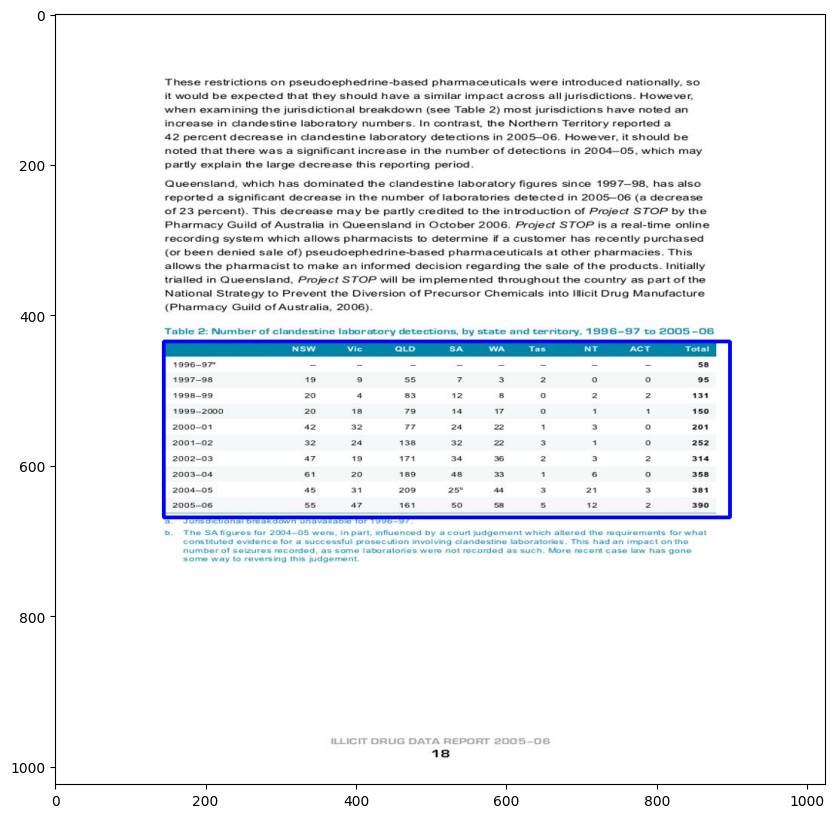

Time Taken on cpu : 0:01:00.965964 secs
Predicted Tables
 ## Table 1
                kad ind nd Cus ok ia
0        1996-97" = = = = = SB - 7 a
1       1997-98 19 9 95 7 3 2 ° ° 9s
2     1998-99 20 4 83 12 8 ° 2 2 431
3  1999-2000 20 18 79 4 v7 o 1 1 150
4     2000-01 42 32 7 24 2 1 3 ° 201
5   2001-02 32 2a 138 32 2 3 1 ° 252
6   2002-03 a7 19 71 34 26 2 3 2 314
7  2003-04 61 20 189 48 33 1 6 ° 358
8     2004-05 a5 a 209 25 a 21 3 3e1
9   2005-06 35 a7 161 50 58 12 2 390


In [13]:
predict(img_path = '../marmot_processed/image/10.1.1.180.553_10.jpg')

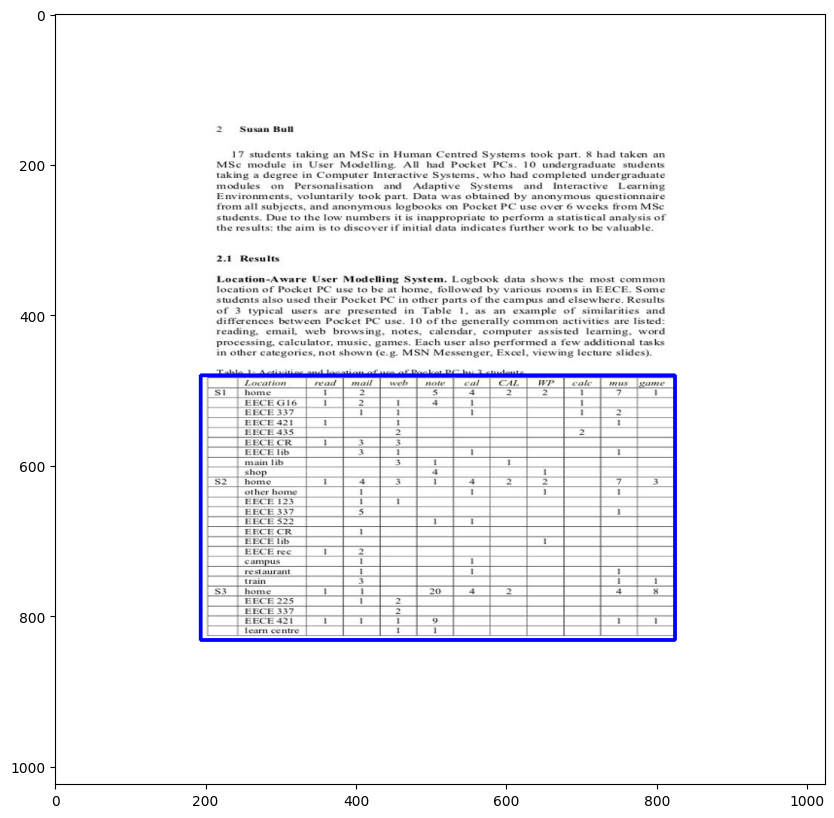

Time Taken on cpu : 0:01:02.186504 secs
Predicted Tables
 ## Table 1
          EECEGI6
0        EECE 337
1        EECE 421
2        EECE 435
3          EECECR
4        EECE lib
5        main Hib
6            sho}
7            home
8      other home
9        EECE 123
10      EECE 337,
11       EECE 522
12         EECECR
13       EECE lib
14       EECE ree
15          train
16           home
17       EECE 335
18       EECE 337
19       EECE 421
20  Tearn contre:


In [16]:
predict(img_path = '../marmot_processed/image/10.1.1.1.2019_2.jpg')

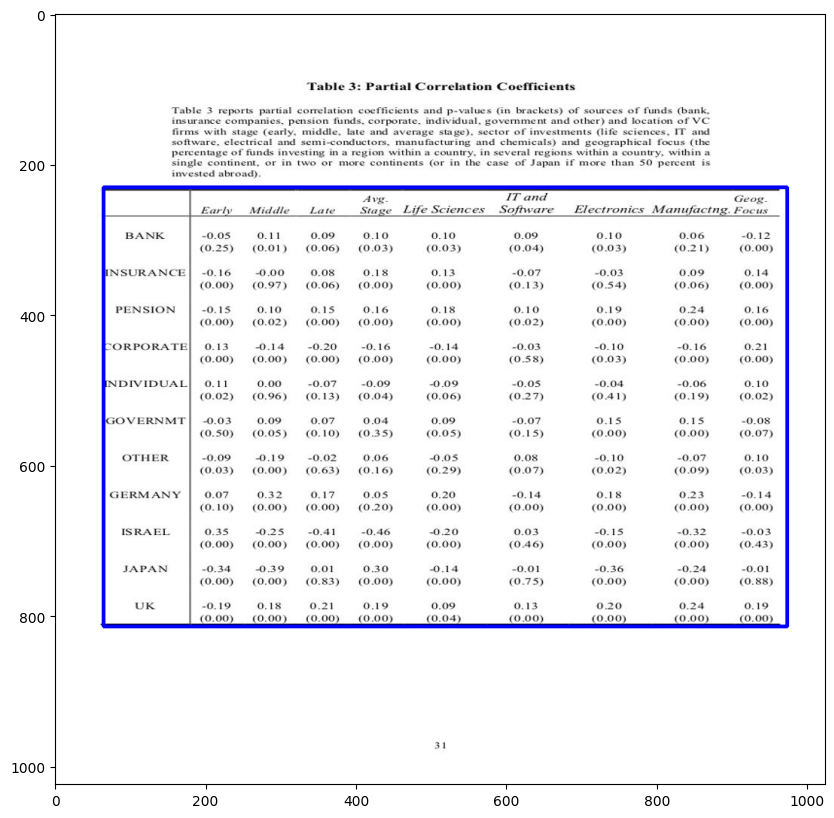

Time Taken on cpu : 0:01:01.556050 secs
Predicted Tables
 ## Table 1
                                                                 Avg.  \
Early       Middle  Late     Stage   Life   Sciences Software      __   
BANK        -0.05   0.11     0.09    0.10   0.10     0.09        0.10   
(0.25)      (0.01)  (0.06)   (0.03)  (0.03) (0.04)   (0.03)     (021)   
INSURANCE|  -0.16   0.00     0.08    0.18,  0.13     -0.07      -0.03   
(0.00)      (0.97)  (0.06)   (0.00)  (0.00) (0.13)   (54)      (0.06)   
PENSION     |       -0.15    0.10    0.15   0.16     O18:        0.10   
(0.00)      (0.02)  (0.00)   (0.00)  (0.00) (0.02)   (0.00)    (0.00)   
CORPORATE|  0.13    0.14     -0.20   -0.16  -0.14    -0.03      -0.10   
(0.00)      (0.00)  (0.00)   (0.00)  (0.00) (0.58)   (0.03)    (0.00)   
INDIVIDUAL] 0.11    0.00     -0.07   09     -0.09    -0.05      -0.04   
(0.02)      (0.96)  (0.13)   (0.04)  (0.06) (27)     41        (0.19)   
GOVERNMT|   0.03    0.09     0.07    0.04   0.09     -0

In [17]:
predict(img_path = '../marmot_processed/image/10.1.1.1.2023_33.jpg')

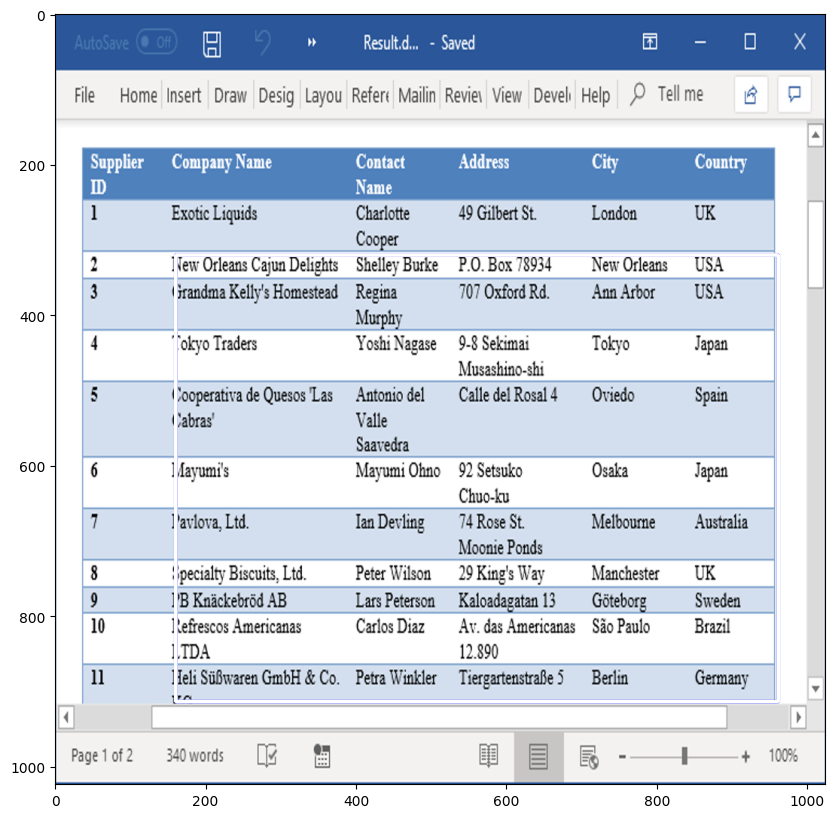

Time Taken on cpu : 0:01:41.651637 secs
Predicted Tables
 ## Table 1
   New Orleans Cajun Delights Shelley Burke P.0.Box 78934 = NewOrleans USA
0   Srandma Kelly's Homestead Regina 707 Oxford Rd...                     
1                                              Murphy                     
2   Tokyo Traders Yoshi Nagase 9-8 Sekimai Tokyo J...                     
3                                       Musashino-shi                     
4   vooperativa de Quesos Las Antoniodel Calle del...                     
5                                       Jabras’ Valle                     
6                                            Saavedra                     
7         Mayumi's Mayumi Ohno 92 Setsuko Osaka Japan                     
8                                             Chuo-ku                     
9   avlova, Ltd. Tan Devling 74 Rose St Melboume A...                     
10                                       Moonie Ponds                     
11  specialty Biscuits, Ltd. Pe

In [15]:
predict(img_path = '../../../../test.png')
# /content/drive/MyDrive/TableNet-pytorch/Training

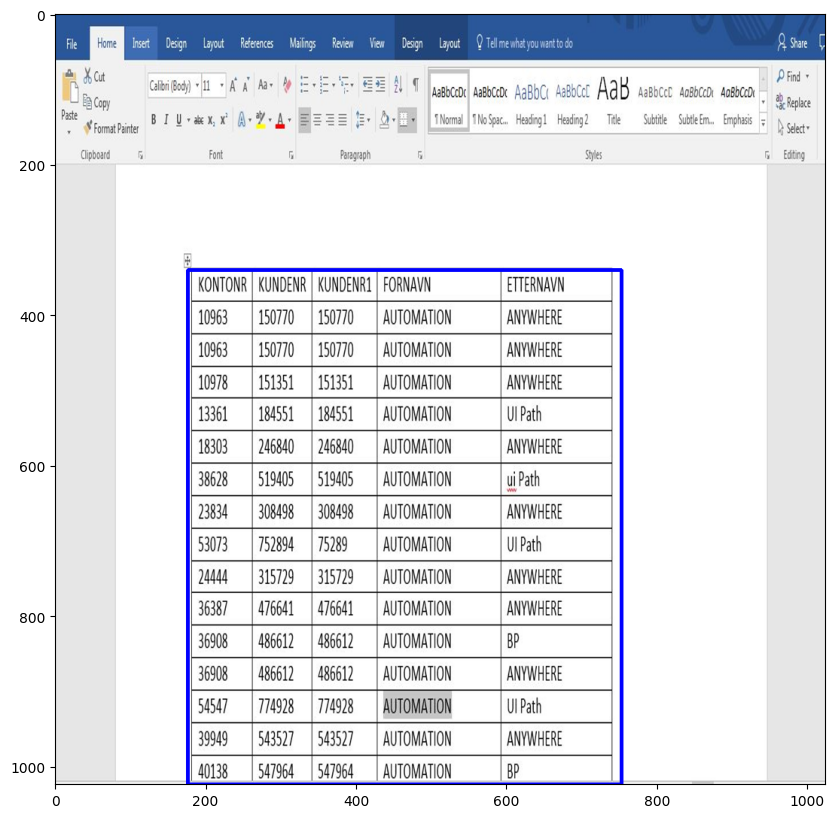

Time Taken on cpu : 0:01:31.877769 secs
Predicted Tables
 ## Table 1
    KONTONR    KUNDENR   KUNDENRI     FORNAVN ETTERNAVN
0      10963     150770    150770      AUTOMATION ANYWI
1      10963     150770    150770      AUTOMATION ANYWI
2      10978     151351    151351      AUTOMATION ANYWI
3      13361     184551    184551    AUTOMATION UI Pat!
4      18303     246840    246840      AUTOMATION ANYWI
5      38628     519405    519405    AUTOMATION ui Pat!
6      23834     308498   308498.      AUTOMATION ANYWI
7      53073     752894     75289     AUTOMATION UI Pat
8      24444     315729   315729 _     AUTOMATION ANYWI
9      36387     476641    476641      AUTOMATION ANYWI
10     36908     486612    486612         AUTOMATION BP
11     36908     486612    486612      AUTOMATION ANYWI
12     54547     774928    774928    AUTOMATION UI Pat!
13     39949     543527    543527      AUTOMATION ANYWI
14     40138     547964    547964         AUTOMATION BP


In [16]:
predict(img_path = '../../../../test2.jpeg')


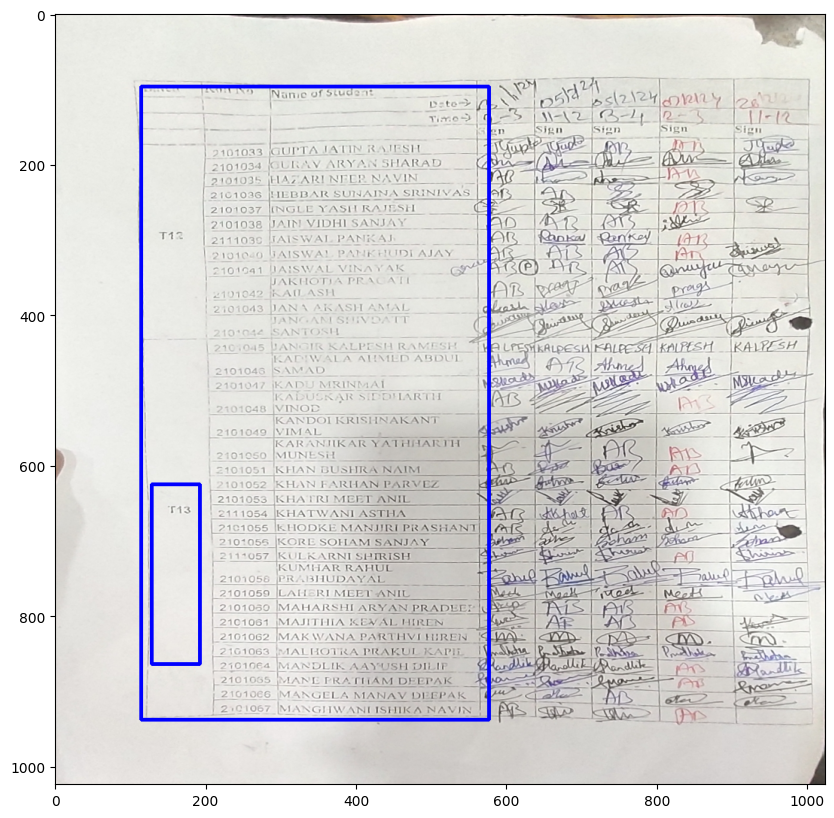

Time Taken on cpu : 0:01:33.373916 secs
Predicted Tables
 ## Table 1
                                            o
2101036               MEBBAR SUNAINA SRINIVAS
2101037 EL                               None
2101038 VIDHI SANJAY                     None
2111038 }                                None
2101040 FAISWA!                          None
NaN                                 2101059 R
2101050 IMAHARSHI AR                     None
NaN                                   2101064
2101062                                  None
\                                        None
 ## Table 2
Empty DataFrame
Columns: [113]
Index: []


In [17]:
predict(img_path = '../../../../IMG_20240321_185515.jpg')

In [11]:
!which tesseract


# TableNet
```
TableNet{
  1: BaseModel(DenseNet) (6,951,808 params),
  2: conv6 (328,192 params),
  3: TableDecoder (885,377 params),
  4: ColumnDecoder (951,169 params),
} ( 9,116,546 params)
```

# BASE MODEL
```
(base_model): DenseNet(
    (densenet_out_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), 9,408 params
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 128 params
      (2): ReLU(inplace=True), 0 params
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), 0 params
      (4): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 128 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 8,192 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 45,440 params
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 192 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 12,288 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 49,600 params
        (denselayer3): _DenseLayer(
          (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 16,384 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 53,760 params
        (denselayer4): _DenseLayer(
          (norm1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 320 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 20,480 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 57,920 params
        (denselayer5): _DenseLayer(
          (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 384 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 24,576 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 62,080 params
        (denselayer6): _DenseLayer(
          (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 448 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 28,672 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 66,240 params
      ), 335,040 params
      (5): _Transition(
        (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 512 params
        (relu): ReLU(inplace=True), 0 params
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 32,768 params
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0), 0 params
      ), 33,280 params
      (6): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 16,384 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 53,760 params
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 320 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 20,480 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 57,920 params
        (denselayer3): _DenseLayer(
          (norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 384 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 24,576 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 62,080 params
        (denselayer4): _DenseLayer(
          (norm1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 448 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(224, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 28,672 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 66,240 params
        (denselayer5): _DenseLayer(
          (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 512 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 32,768 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 70,400 params
        (denselayer6): _DenseLayer(
          (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 576 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 36,864 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 74,560 params
        (denselayer7): _DenseLayer(
          (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 640 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 40,960 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 78,720 params
        (denselayer8): _DenseLayer(
          (norm1): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 704 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(352, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 45,056 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 82,880 params
        (denselayer9): _DenseLayer(
          (norm1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 768 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 49,152 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 87,040 params
        (denselayer10): _DenseLayer(
          (norm1): BatchNorm2d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 832 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(416, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 53,248 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 91,200 params
        (denselayer11): _DenseLayer(
          (norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 896 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 57,344 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 95,360 params
        (denselayer12): _DenseLayer(
          (norm1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 960 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(480, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 61,440 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 99,520 params
      ), 919,680 params
      (7): _Transition(
        (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,024 params
        (relu): ReLU(inplace=True), 0 params
        (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False), 131,072 params
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0), 0 params
      ), 132,096 params
    ), 1,429,632 params
    (densenet_out_2): Sequential(
      (8): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 512 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 32,768 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 70,400 params
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 576 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(288, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 36,864 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 74,560 params
        (denselayer3): _DenseLayer(
          (norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 640 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 40,960 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 78,720 params
        (denselayer4): _DenseLayer(
          (norm1): BatchNorm2d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 704 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(352, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 45,056 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 82,880 params
        (denselayer5): _DenseLayer(
          (norm1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 768 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(384, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 49,152 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 87,040 params
        (denselayer6): _DenseLayer(
          (norm1): BatchNorm2d(416, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 832 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(416, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 53,248 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 91,200 params
        (denselayer7): _DenseLayer(
          (norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 896 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(448, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 57,344 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 95,360 params
        (denselayer8): _DenseLayer(
          (norm1): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 960 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(480, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 61,440 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 99,520 params
        (denselayer9): _DenseLayer(
          (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,024 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 65,536 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 103,680 params
        (denselayer10): _DenseLayer(
          (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,088 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(544, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 69,632 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 107,840 params
        (denselayer11): _DenseLayer(
          (norm1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,152 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 73,728 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 112,000 params
        (denselayer12): _DenseLayer(
          (norm1): BatchNorm2d(608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,216 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 77,824 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 116,160 params
        (denselayer13): _DenseLayer(
          (norm1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,280 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(640, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 81,920 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 120,320 params
        (denselayer14): _DenseLayer(
          (norm1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,344 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(672, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 86,016 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 124,480 params
        (denselayer15): _DenseLayer(
          (norm1): BatchNorm2d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,408 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(704, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 90,112 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 128,640 params
        (denselayer16): _DenseLayer(
          (norm1): BatchNorm2d(736, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,472 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(736, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 94,208 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 132,800 params
        (denselayer17): _DenseLayer(
          (norm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,536 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 98,304 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 136,960 params
        (denselayer18): _DenseLayer(
          (norm1): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,600 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(800, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 102,400 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 141,120 params
        (denselayer19): _DenseLayer(
          (norm1): BatchNorm2d(832, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,664 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 106,496 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 145,280 params
        (denselayer20): _DenseLayer(
          (norm1): BatchNorm2d(864, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,728 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(864, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 110,592 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 149,440 params
        (denselayer21): _DenseLayer(
          (norm1): BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,792 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 114,688 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 153,600 params
        (denselayer22): _DenseLayer(
          (norm1): BatchNorm2d(928, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,856 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(928, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 118,784 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 157,760 params
        (denselayer23): _DenseLayer(
          (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,920 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 122,880 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 161,920 params
        (denselayer24): _DenseLayer(
          (norm1): BatchNorm2d(992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,984 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 126,976 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 166,080 params
      ), 2,837,760 params
      (9): _Transition(
        (norm): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 2,048 params
        (relu): ReLU(inplace=True), 0 params
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False), 524,288 params
        (pool): AvgPool2d(kernel_size=2, stride=2, padding=0), 0 params
      ), 526,336 params
    ), 3,364,096 params
    (densenet_out_3): Sequential(
      (10): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,024 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 65,536 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 103,680 params
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,088 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(544, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 69,632 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 107,840 params
        (denselayer3): _DenseLayer(
          (norm1): BatchNorm2d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,152 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(576, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 73,728 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 112,000 params
        (denselayer4): _DenseLayer(
          (norm1): BatchNorm2d(608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,216 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(608, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 77,824 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 116,160 params
        (denselayer5): _DenseLayer(
          (norm1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,280 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(640, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 81,920 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 120,320 params
        (denselayer6): _DenseLayer(
          (norm1): BatchNorm2d(672, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,344 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(672, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 86,016 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 124,480 params
        (denselayer7): _DenseLayer(
          (norm1): BatchNorm2d(704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,408 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(704, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 90,112 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 128,640 params
        (denselayer8): _DenseLayer(
          (norm1): BatchNorm2d(736, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,472 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(736, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 94,208 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 132,800 params
        (denselayer9): _DenseLayer(
          (norm1): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,536 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(768, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 98,304 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 136,960 params
        (denselayer10): _DenseLayer(
          (norm1): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,600 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(800, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 102,400 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 141,120 params
        (denselayer11): _DenseLayer(
          (norm1): BatchNorm2d(832, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,664 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(832, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 106,496 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 145,280 params
        (denselayer12): _DenseLayer(
          (norm1): BatchNorm2d(864, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,728 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(864, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 110,592 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 149,440 params
        (denselayer13): _DenseLayer(
          (norm1): BatchNorm2d(896, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,792 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(896, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 114,688 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 153,600 params
        (denselayer14): _DenseLayer(
          (norm1): BatchNorm2d(928, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,856 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(928, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 118,784 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 157,760 params
        (denselayer15): _DenseLayer(
          (norm1): BatchNorm2d(960, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,920 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(960, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 122,880 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 161,920 params
        (denselayer16): _DenseLayer(
          (norm1): BatchNorm2d(992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 1,984 params
          (relu1): ReLU(inplace=True), 0 params
          (conv1): Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False), 126,976 params
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 256 params
          (relu2): ReLU(inplace=True), 0 params
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False), 36,864 params
        ), 166,080 params
      ), 2,158,080 params
    ), 2,158,080 params
  ), 6,951,808 params
  ```

# Conv 6
```
(conv6): Sequential(
    (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1)), 262,400 params
    (1): ReLU(inplace=True), 0 params
    (2): Dropout(p=0.8, inplace=False), 0 params
    (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)), 65,792 params
    (4): ReLU(inplace=True), 0 params
    (5): Dropout(p=0.8, inplace=False), 0 params
  ), 328,192 params
```

#  Table Decoder
```
(table_decoder): TableDecoder(
    (conv_7_table): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)), 65,792 params
    (upsample_1_table): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(1, 1)), 32,896 params
    (upsample_2_table): ConvTranspose2d(640, 256, kernel_size=(2, 2), stride=(2, 2)), 655,616 params
    (upsample_3_table): ConvTranspose2d(512, 1, kernel_size=(16, 16), stride=(16, 16)), 131,073 params
  ), 885,377 params
```
# Column Decoder
```
(column_decoder): ColumnDecoder(
    (conv_8_column): Sequential(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)), 65,792 params
      (1): ReLU(inplace=True), 0 params
      (2): Dropout(p=0.8, inplace=False), 0 params
      (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1)), 65,792 params
    ), 131,584 params
    (upsample_1_column): ConvTranspose2d(256, 128, kernel_size=(1, 1), stride=(1, 1)), 32,896 params
    (upsample_2_column): ConvTranspose2d(640, 256, kernel_size=(2, 2), stride=(2, 2)), 655,616 params
    (upsample_3_column): ConvTranspose2d(512, 1, kernel_size=(16, 16), stride=(16, 16)), 131,073 params
  ), 951,169 params
```

